# `Soundscapy` - Quick Start Guide

By Andrew Mitchell, Research Fellow, University College London

## Background

`Soundscapy` is a python toolbox for analysing quantitative soundscape data. Urban soundscapes are typically assessed through surveys which ask respondents how they perceive the given soundscape. Particularly when collected following the technical specification ISO 12913, these surveys can constitute quantitative data about the soundscape perception. As proposed in *How to analyse and represent quantitative soundscape data* [(Mitchell, Aletta, & Kang, 2022)](https://asa.scitation.org/doi/full/10.1121/10.0009794), in order to describe the soundscape perception of a group or of a location, we should consider the distribution of responses. `Soundscapy`'s approach to soundscape analysis follows this approach and makes it simple to process soundscape data and visualise the distribution of responses. 

For more information on the theory underlying the assessments and forms of data collection, please see ISO 12913-Part 2, *The SSID Protocol* [(Mitchell, *et al.*, 2020)](https://www.mdpi.com/2076-3417/10/7/2397), and *How to analyse and represent quantitative soundscape data*.

## This Notebook

The purpose of this notebook is to give a brief overview of how `Soundscapy` works and how to quickly get started using it to analyse your own soundscape data. The example dataset used is *The International Soundscape Database (ISD)* (Mitchell, *et al.*, 2021), which is publicly available at [Zenodo](https://zenodo.org/record/6331810) and is free to use. `Soundscapy` expects data to follow the format used in the ISD, but can be adapted for similar datasets.

----------

## Installation

`Soundscapy` is currently under active development. To install with `pip`:

```
pip install soundscapy
```

----

### Logging

`Soundscapy` uses the `loguru` module to provide information about what it is doing. By default, the log level is set to `WARNING`, which will only provide information when there is something to worry about. However, if you want to get more information about what `Soundscapy` is doing you can set the log level to `INFO` or `DEBUG`, using `soundscape.logging.set_log_level('INFO')`. For the sake of this demo, we'll set the log level to `INFO`.

## Working with data

### Loading data

Data can be loaded as normal using `pandas`' `read_csv()` or `read_excel()` functions. However, we have made a built in function to access the ISD directly from the Zenodo URL, which will automatically default to the latest version of the ISD. 

In [1]:
%load_ext autoreload
%autoreload 2

# Import Soundscapy
import soundscapy as sspy
from soundscapy.databases import isd
from soundscapy.logging import set_log_level
set_log_level("INFO")

df = isd.load()
df

2024-08-15 16:30:42.394 | INFO     | soundscapy.surveys.survey_utils:<module>:181 - Core survey utilities module loaded.
2024-08-15 16:30:42.395 | INFO     | soundscapy.surveys.processing:<module>:522 - Survey processing module loaded.
2024-08-15 16:30:42.395 | INFO     | soundscapy.databases.isd:<module>:545 - ISD module loaded
2024-08-15 16:30:42.396 | INFO     | soundscapy.databases.satp:<module>:110 - SATP module loaded
2024-08-15 16:30:42.402 | INFO     | soundscapy.logging:set_log_level:51 - Log level set to INFO
2024-08-15 16:30:42.425 | INFO     | soundscapy.databases.isd:load:84 - Loaded ISD data from Soundscapy's included CSV file.


,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,RA_cp90_Max,RA_cp95_Max,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.0,-10.29
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.0,-10.29
2,CarloV,CarloV2,2CV13,1430,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,DadongSquare,DadongSquare4,DSQ4116,ZJY11,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3585,DadongSquare,DadongSquare4,DSQ4117,ZJY12,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3586,DadongSquare,DadongSquare4,DSQ4118,ZJY13,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3587,DadongSquare,DadongSquare4,DSQ4119,ZJY14,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data included

The ISD contains two primary types of data - surveys and acoustic metrics. The surveys include several blocks of questions, the most important of which are the Perceptual Attribute Questions (PAQS). These form the 8 descriptors of the soundscape circumplex - pleasant, vibrant, eventful, chaotic, annoying, monotonous, uneventful, and calm. In addition, each survey includes other information about the soundscape and demographic characteristics (age, gender, etc.). Finally, the survey section includes identifiers of when and where the survey was conducted - the LocationID, SessionID, latitude, longitude, start_time, etc. 

The final bit of information for the survey is the `GroupID`. When stopping respondents in the survey space, they were often stopped as a group, for instance a couple walking through the space would be approached together and given the same `GroupID`. While each group completes the survey, a binaural audio recording is taken, typically lasting about 30 seconds. It is from these recordings that the acoustic data is calculated. Therefore, each `GroupID` can be connected to something like 1 to 10 surveys, and to one recording, or one set of acoustic features.

Within the acoustic data are a set of psychoacoustic analyses calculated for each recording. For each metric, originally one value is calculated for each channel (right and left ear), and the maximum of the to channels is what is shown here.


In [2]:
df.shape

(3589, 142)

### Validating the dataset
 
In order to validate that the dataset includes the data we would expect, and to check for missing or incorrect PAQ data, we use the `isd.validate()` function. This method can also rename the PAQ columns if necessary.

In [3]:
df, excl = isd.validate(df)
df

2024-08-15 16:30:42.483 | INFO     | soundscapy.databases.isd:validate:195 - Validating ISD data
2024-08-15 16:30:42.673 | INFO     | soundscapy.surveys.processing:likert_data_quality:280 - Found 56 samples with data quality issues
2024-08-15 16:30:42.676 | INFO     | soundscapy.databases.isd:validate:205 - Removed 56 rows with invalid PAQ data


,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,RA_cp90_Max,RA_cp95_Max,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.0,-10.29
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.0,-10.29
2,CarloV,CarloV2,2CV13,1430,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,DadongSquare,DadongSquare4,DSQ4116,ZJY11,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3585,DadongSquare,DadongSquare4,DSQ4117,ZJY12,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3586,DadongSquare,DadongSquare4,DSQ4118,ZJY13,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3587,DadongSquare,DadongSquare4,DSQ4119,ZJY14,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When samples are found which need to be excluded based on the PAQ quality checks, a dataframe with these samples will be returned. Then we can take a look at which ones were excluded and why.

In [4]:
sspy.surveys.return_paqs(excl)

,RecordID,GroupID,SessionID,LocationID,PAQ1,PAQ2,PAQ3,PAQ4,PAQ5,PAQ6,PAQ7,PAQ8
6,1428,2CV21,CarloV2,CarloV,4.0,3.0,4.0,4.0,NaN,4.0,3.0,4.0
9,1437,2CV32,CarloV2,CarloV,5.0,4.0,3.0,3.0,2.0,4.0,NaN,5.0
13,1441,2CV32,CarloV2,CarloV,4.0,NaN,3.0,4.0,2.0,5.0,3.0,3.0
30,1418,2CV62,CarloV2,CarloV,5.0,5.0,4.0,2.0,1.0,3.0,2.0,NaN
32,1420,2CV62,CarloV2,CarloV,5.0,5.0,4.0,1.0,NaN,4.0,2.0,2.0
46,1455,BIB5,PlazaBibRambla1,PlazaBibRambla,5.0,3.0,3.0,1.0,NaN,1.0,3.0,5.0
413,52,ML112,SanMarco1,SanMarco,4.0,4.0,4.0,4.0,1.0,2.0,NaN,2.0
428,85,ML211,SanMarco2,SanMarco,4.0,2.0,4.0,3.0,2.0,4.0,NaN,2.0
485,410,PL202,PancrasLock2,PancrasLock,4.0,2.0,2.0,2.0,4.0,4.0,2.0,NaN
655,439,RP110,RegentsParkJapan1,RegentsParkJapan,5.0,5.0,4.0,1.0,1.0,1.0,NaN,4.0


### Calculating the ISOPleasant and ISOEventful coordinate values

The analysis methods used by `Soundscapy` are based firstly on converting the 8 PAQs into their projected pleasantness and eventfulness coordinate values (called ISOPleasant and ISOEventful).

Now, calculate the ISOCoordinate values.

In [5]:
df = sspy.surveys.add_iso_coords(df)
df

2024-08-15 16:30:42.873 | INFO     | soundscapy.surveys.processing:calculate_iso_coords:109 - Calculated ISO coordinates for 3533 samples
2024-08-15 16:30:42.875 | INFO     | soundscapy.surveys.processing:add_iso_coords:229 - Added ISO coordinates to DataFrame with column names: ('ISOPleasant', 'ISOEventful')


,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.0,-10.29,2.196699e-01,-0.133883
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.0,-10.29,-4.267767e-01,0.530330
2,CarloV,CarloV2,2CV13,1430,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33,6.767767e-01,-0.073223
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33,6.035534e-01,-0.146447
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.3,-17.33,4.571068e-01,-0.146447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,DadongSquare,DadongSquare4,DSQ4116,ZJY11,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.379608e-16,0.042893
3585,DadongSquare,DadongSquare4,DSQ4117,ZJY12,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.379608e-16,-0.146447
3586,DadongSquare,DadongSquare4,DSQ4118,ZJY13,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.125631e-01,0.280330
3587,DadongSquare,DadongSquare4,DSQ4119,ZJY14,2020-09-21,2020-09-21,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.732233e-01,0.133883


`Soundscapy` expects the PAQ values to be Likert scale values ranging from 1 to 5 by default, as specified in ISO 12913 and the SSID Protocol. However, it is possible to use data which, although structured the same way, has a different range of values. For instance this could be a 7-point Likert scale, or a 0 to 100 scale. By passing these numbers both to `validate_dataset()` and `add_paq_coords()` as the `val_range`, `Soundscapy` will check that the data conforms to what is expected and will automatically scale the ISOCoordinates from -1 to +1 depending on the original value range. 

For example:

In [6]:
import pandas as pd
val_range = (0, 100)
sample_transform = {
    "RecordID": ["EX1", "EX2"],
    "pleasant": [40, 25],
    "vibrant": [45, 31],
    "eventful": [41, 54],
    "chaotic": [24, 56],
    "annoying": [8, 52],
    "monotonous": [31, 55],
    "uneventful": [37, 31],
    "calm": [40, 10],
}
sample_transform = pd.DataFrame().from_dict(sample_transform)
sample_transform, excl = isd.validate(sample_transform, val_range=val_range)

2024-08-15 16:30:42.895 | INFO     | soundscapy.databases.isd:validate:195 - Validating ISD data
2024-08-15 16:30:42.896 | INFO     | soundscapy.surveys.processing:likert_data_quality:283 - PAQ data quality check passed
2024-08-15 16:30:42.896 | INFO     | soundscapy.databases.isd:validate:208 - All PAQ data passed quality checks


In [7]:
sample_transform = sspy.surveys.add_iso_coords(sample_transform, val_range=val_range)
sample_transform

2024-08-15 16:30:42.908 | INFO     | soundscapy.surveys.processing:calculate_iso_coords:109 - Calculated ISO coordinates for 2 samples
2024-08-15 16:30:42.909 | INFO     | soundscapy.surveys.processing:add_iso_coords:229 - Added ISO coordinates to DataFrame with column names: ('ISOPleasant', 'ISOEventful')


,RecordID,PAQ1,PAQ2,PAQ3,PAQ4,PAQ5,PAQ6,PAQ7,PAQ8,ISOPleasant,ISOEventful
0,EX1,40,45,41,24,8,31,37,40,0.220416,0.010711
1,EX2,25,31,54,56,52,55,31,10,-0.316863,0.159706


### More filtering

`Soundscapy` includes methods for several filters that are normally needed, such as filtering by `LocationID` or `SessionID`.

In [8]:
isd.select_location_ids(df, ['CamdenTown', 'PancrasLock'])

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
48,CamdenTown,CamdenTown1,CT101,525,2019-05-02 11:40:44,2019-05-02 11:43:24,51.539124,-0.142624,eng,engISO2018,...,-5.58,-6.52,73.66,44.15,35.61,12.57,-3.47,-4.39,-2.196699e-01,0.426777
49,CamdenTown,CamdenTown1,CT101,526,2019-05-02 11:41:57,2019-05-02 11:44:21,51.539124,-0.142624,eng,engISO2018,...,-5.58,-6.52,73.66,44.15,35.61,12.57,-3.47,-4.39,-1.839478e-16,0.250000
50,CamdenTown,CamdenTown1,CT101,561,2019-05-02 11:40:44,2019-05-02 11:43:24,51.539124,-0.142624,eng,engISO2018,...,-5.58,-6.52,73.66,44.15,35.61,12.57,-3.47,-4.39,-4.696699e-01,0.176777
51,CamdenTown,CamdenTown1,CT102,560,2019-05-02 11:50:10,2019-05-02 11:53:03,51.539124,-0.142624,eng,engISO2018,...,-0.47,-3.57,72.15,44.04,36.22,14.34,-0.59,-1.59,1.035534e-01,-0.750000
52,CamdenTown,CamdenTown1,CT103,527,2019-05-02 11:49:06,2019-05-02 11:54:24,51.539124,-0.142624,eng,engISO2018,...,-4.07,-8.23,68.37,40.70,32.20,8.60,-5.41,-6.56,2.500000e-01,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,PancrasLock,PancrasLock2,PL233,403,2019-04-12 14:05:24,2019-04-12 14:10:24,51.536588,-0.127969,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.303301e-01,0.116117
524,PancrasLock,PancrasLock2,PL234,395,2019-04-12 14:09:14,2019-04-12 14:11:48,51.536588,-0.127969,eng,engISO2018,...,-0.68,-10.19,70.30,33.31,27.54,9.42,-3.58,-5.25,3.535534e-01,-0.500000
525,PancrasLock,PancrasLock2,PL299,377,2019-04-12 12:14:13,2019-04-12 12:21:25,51.536588,-0.127969,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.035534e-01,-0.085786
1295,CamdenTown,CamdenTown3,CT323,10009,2019-05-20 13:49:00,2019-05-20 13:51:00,51.539173,-0.142602,spa,spaSSIDv1,...,-1.10,1.25,67.17,53.46,49.38,32.47,7.47,6.15,2.500000e-01,0.103553


In [9]:
isd.select_session_ids(df, ['RegentsParkJapan1']).head()

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
645,RegentsParkJapan,RegentsParkJapan1,RP101,471,2019-04-30 12:10:00,2019-04-30 12:17:00,51.526795,-0.153023,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.106602e-01
646,RegentsParkJapan,RegentsParkJapan1,RP101,472,2019-04-30 12:10:00,2019-04-30 12:17:00,51.526795,-0.153023,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926777,2.374369e-01
647,RegentsParkJapan,RegentsParkJapan1,RP102,470,2019-04-30 12:13:00,2019-04-30 12:17:00,51.526795,-0.153023,eng,engISO2018,...,-0.39,8.68,55.59,44.77,38.94,29.02,11.05,10.53,0.133883,1.338835e-01
648,RegentsParkJapan,RegentsParkJapan1,RP102,473,2019-04-30 12:13:00,2019-04-30 12:16:00,51.526795,-0.153023,eng,engISO2018,...,-0.39,8.68,55.59,44.77,38.94,29.02,11.05,10.53,0.103553,-9.197389e-17
649,RegentsParkJapan,RegentsParkJapan1,RP103,468,2019-04-30 12:10:00,2019-04-30 12:10:00,51.526795,-0.153023,eng,engISO2018,...,-0.36,10.97,57.59,42.94,41.49,30.97,13.19,12.70,0.250000,0.000000e+00


However, if more complex filters or some other custom filter is needed, `pandas` provides a very nice approach with its `query()` method. For instance, if we wanted to filter by gender:

In [10]:
df.query("gen00 == 'Female'")

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29,0.219670,-0.133883
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29,-0.426777,0.530330
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33,0.603553,-0.146447
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33,0.457107,-0.146447
10,CarloV,CarloV2,2CV32,1438,2019-05-16 18:56:00,2019-05-16 19:00:00,37.17685,-3.590392,eng,engISO2018,...,-0.57,-16.16,58.38,32.16,24.88,3.93,-13.25,-14.21,0.030330,-0.133883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,PingshanStreet,PingshanStreet2,PS2227,39,2019-04-22 12:05:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.457107,0.250000
1979,PingshanStreet,PingshanStreet2,PS2227,40,2019-04-22 12:06:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.176777,0.323223
1983,PingshanStreet,PingshanStreet2,PS2229,44,2019-04-22 12:12:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.603553,-0.267767
1985,PingshanStreet,PingshanStreet2,PS2229,46,2019-04-22 12:13:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.073223,0.116117


Or a more complex filter like women over 50:

In [11]:
df.query("gen00 == 'Female' and age00 > 50")

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.176850,-3.590392,eng,engISO2018,...,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29,2.196699e-01,-1.338835e-01
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.176850,-3.590392,eng,engISO2018,...,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29,-4.267767e-01,5.303301e-01
17,CarloV,CarloV2,2CV52,1425,2019-05-16 18:52:00,2019-05-16 19:02:00,37.176850,-3.590392,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.535534e-01,-9.197389e-17
45,PlazaBibRambla,PlazaBibRambla1,BIB5,1454,2019-05-15 12:39:00,2019-05-15 12:49:00,37.175395,-3.599808,eng,engISO2018,...,-1.16,-12.63,54.91,38.97,30.39,7.03,-10.09,-11.02,5.606602e-01,2.928932e-01
58,CamdenTown,CamdenTown1,CT108,531,2019-05-02 12:10:52,2019-05-02 12:26:45,51.539124,-0.142624,eng,engISO2018,...,-2.12,-4.44,72.28,45.05,37.19,13.40,-1.88,-2.45,-1.464466e-01,1.464466e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,LianhuashanParkForest,LianhuashanParkForest2,LPF2142,8,2019-04-02 13:18:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.232233e-01,-7.322330e-02
1812,LianhuashanParkForest,LianhuashanParkForest2,LPF2151,23,2019-04-02 14:13:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.267767e-01,-7.322330e-02
1868,PingshanPark,PingshanPark2,PP2080,30,2019-03-30 11:04:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.464466e-01,-6.066017e-02
1869,PingshanPark,PingshanPark2,PP2080,31,2019-03-30 11:04:00,NaN,NaN,NaN,cmn,cmnSSIDv3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.839478e-16,8.578644e-02


All of these filters can also be chained together. So, for instance, to return surveys from women over 50 taken in Camden Town, we would do:

In [12]:
isd.select_location_ids(df, 'CamdenTown').query("gen00 == 'Female' and age00 > 50")

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
58,CamdenTown,CamdenTown1,CT108,531,2019-05-02 12:10:52,2019-05-02 12:26:45,51.539124,-0.142624,eng,engISO2018,...,-2.12,-4.44,72.28,45.05,37.19,13.40,-1.88,-2.45,-1.464466e-01,0.146447
63,CamdenTown,CamdenTown1,CT111,533,2019-05-02 12:29:42,2019-05-02 12:58:56,51.539124,-0.142624,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.142136e-01,-0.457107
104,CamdenTown,CamdenTown3,CT311,593,2019-05-20 12:24:14,2019-05-20 12:28:27,51.539124,-0.142624,eng,engISO2018,...,-4.73,-8.48,76.20,44.21,34.12,11.04,-4.83,-5.99,-1.464466e-01,0.146447
105,CamdenTown,CamdenTown3,CT311,623,2019-05-20 12:25:00,2019-05-20 12:30:00,51.539124,-0.142624,eng,engISO2018,...,-4.73,-8.48,76.20,44.21,34.12,11.04,-4.83,-5.99,1.338835e-01,0.073223
122,CamdenTown,CamdenTown3,CT324,609,2019-05-20 13:51:00,2019-05-20 13:57:00,51.539124,-0.142624,eng,engISO2018,...,-1.53,-9.57,75.83,43.30,33.73,11.88,-5.59,-7.44,1.767767e-01,0.926777
128,CamdenTown,CamdenTown3,CT328,617,2019-05-20 14:13:00,2019-05-20 14:16:00,51.539124,-0.142624,eng,engISO2018,...,-5.89,-1.76,71.56,45.97,38.80,17.59,2.64,1.16,-4.393398e-01,0.250000
132,CamdenTown,CamdenTown4,CT403,1220,2019-07-13 12:31:40,2019-07-13 12:35:30,51.539140,-0.142648,eng,engISO2018,...,-1.32,-3.24,71.78,49.81,42.16,16.53,0.54,-0.65,-4.598694e-17,0.603553


## Plotting

Probably the most important part of the `Soundscapy` package is its methods for plotting soundscape circumplex data. Making use of the `seaborn kdeplot()`, we can visualise the distribution of responses within the soundscape circumplex. 

### Scatter plots

The most basic plot is the `circumplex_scatter()`. 

First, we filter down to one location that we want to look at. Then, using the `circumplex_scatter()`, we can create a default formatted plot:

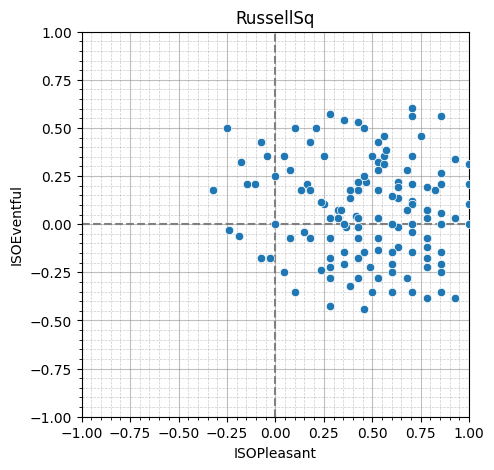

In [13]:
from soundscapy.plotting.circumplex_plot import CircumplexPlot, CircumplexPlotParams, Backend, \
    create_circumplex_subplots

scatter = CircumplexPlot(isd.select_location_ids(df, ['RussellSq']), CircumplexPlotParams(title="RussellSq"))
scatter.scatter(apply_styling=True).show()

In [14]:
scatter = CircumplexPlot(isd.select_location_ids(df, ['RussellSq']), CircumplexPlotParams(title="RussellSq"), backend=Backend.PLOTLY)
scatter.scatter().show()

TypeError: PlotlyBackend() takes no arguments

In [ ]:
from soundscapy.plotting.circumplex_plot import scatter_plot
import matplotlib.pyplot as plt
ax = scatter_plot(isd.select_location_ids(df, ['RussellSq']))
plt.show()

In [ ]:
ax = scatter_plot(
    isd.select_location_ids(df, ['RussellSq', 'EustonTap']),
    hue="LocationID",
    title="My Custom Plot",
    diagonal_lines=True,
    legend_location="upper right",
)
plt.show()

In [ ]:
from soundscapy.plotting.stylers import StyleOptions

custom_style = StyleOptions(figsize=(8, 8), bw_adjust=1.5)
ax = scatter_plot(
    isd.select_location_ids(df, ['RussellSq']),
    figsize=(8, 8),
    extra_params={"s": 100}  # Increase marker size
)
plt.show()

In [ ]:
from soundscapy.plotting.circumplex_plot import density_plot

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, location in enumerate(df["LocationID"].unique()[:4]):
    density_plot(
        sspy.isd.select_location_ids(df, location),
        ax=axes.flatten()[i],
        title=location,
        hue="SessionID",
        simple_density=True,
        legend=True,
        incl_outline=True
    )

plt.tight_layout()
plt.show()

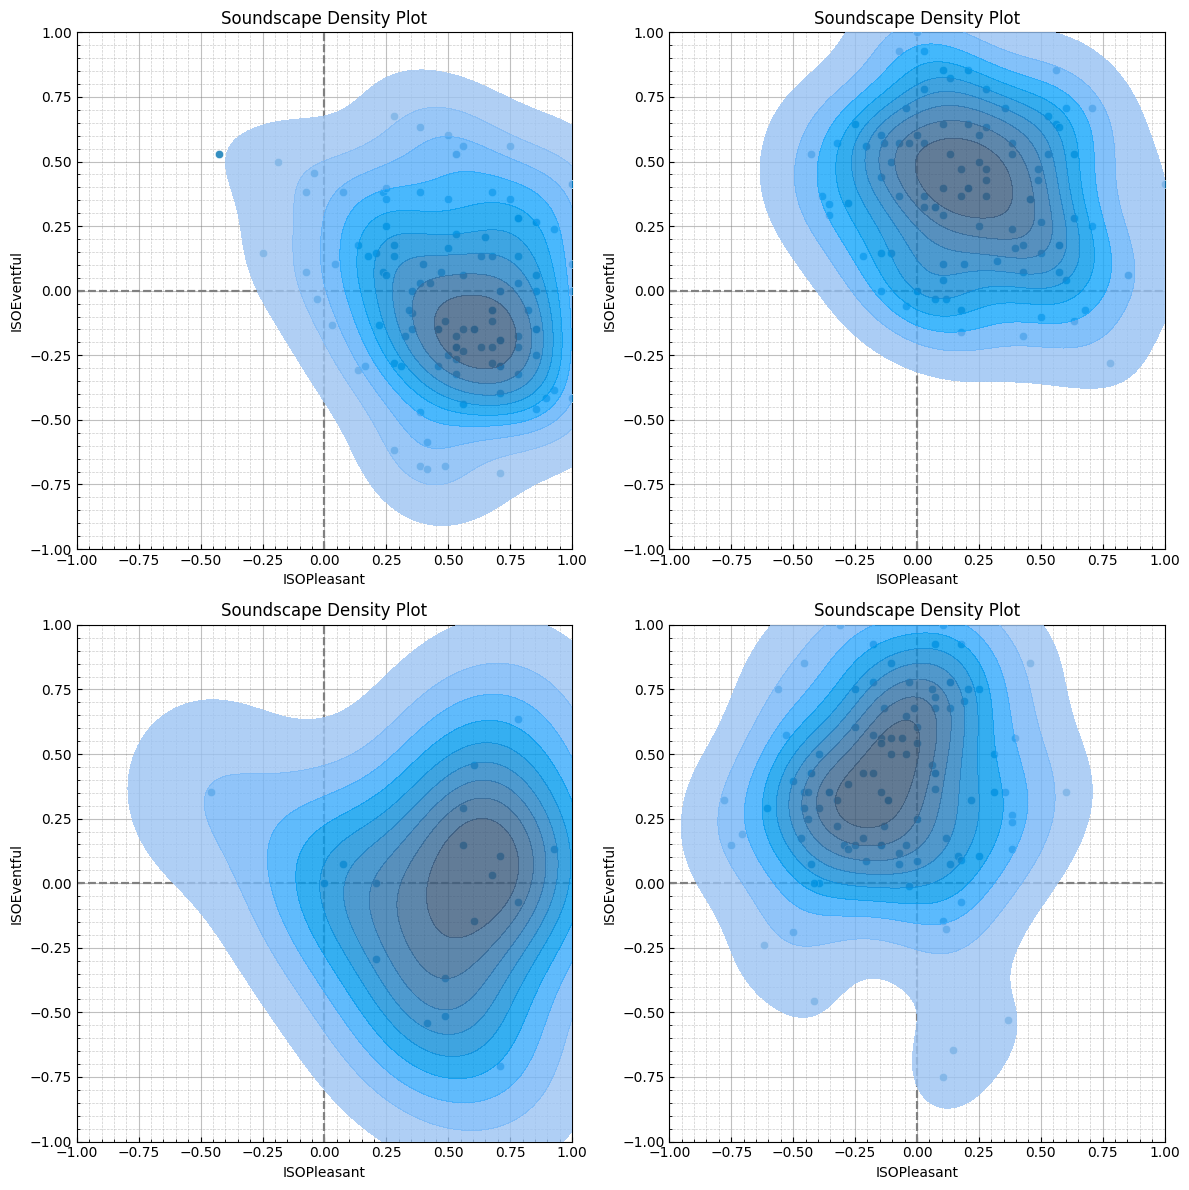

In [27]:
from soundscapy.plotting.circumplex_plot import create_circumplex_subplots
import matplotlib.pyplot as plt
data_list = [sspy.isd.select_location_ids(df, loc) for loc in df["LocationID"].unique()[:4]]
fig = create_circumplex_subplots(
    data_list,
    plot_type="density",
    nrows=2,
    ncols=2,
    figsize=(12, 12),
    legend=True,
    incl_scatter=True,
)
plt.show()

Each point in this scatter plot represents the ISOCoordinate values of one survey taken in Russell Square during all of the sessions. 

We can see that the `circumplex_scatter()` has added some customisations on top of the underlying `seaborn` plots. The first is to automatically scale the plot area to the -1 to +1 bounding of the circumplex. Second is the inclusion of a grid highlighting the typically quadrants of the circumplex. Finally, customised labels which make the relationship of the ISOPleasant and ISOEventful values more clear. 

This plot can be further customised though. For instance, if you don't like or need those custom primary labels, we can remove them by setting `prim_labels = False`. We could also add labels for the diagonal circumplex axes with `diagonal_lines = True`.

In [ ]:
from soundscapy.plotting.circumplex_plot import scatter_plot

scatter_plot(isd.select_location_ids(df, ['RussellSq']), diagonal_lines=False, show=True)


It's also often very useful to plot the different sessions taken in the same location with different colours. This is done with the `hue` parameter. At the same time, we'll also add a legend and make the scatter points larger.

In [ ]:
scatter_plot(
    isd.select_location_ids(df, ['RussellSq']),
    hue='SessionID',
    backend=Backend.PLOTLY,
    show=True
    )

### Distribution Plots

The real power of `Soundscapy` is in creating plots of the distribution of soundscape assessments. The interface for doing this is the same as the scatter plots above.

In [ ]:
density_plot = CircumplexPlot(isd.select_location_ids(df, ['RussellSq']), CircumplexPlotParams(title="RussellSq"), backend=Backend.SEABORN)
density_plot.density()
density_plot.show()


This can be customised in the same ways as the scatter plots. To see how the scatter points and the density heatmap are related, we can add scatter points to the density plot.

In [ ]:
sspy.plotting.density(
    isd.select_location_ids(df, ['RussellSq']),
    incl_scatter=True,
    alpha=0.75,
    hue="LocationID"
    )

*How to analyse* proposes a method for simplifying this plot, allowing easy comparison between multiple soundscapes. In the simplified version, rather than showing the full distribution heatmap, we plot only the 50th percentile density curve, showing the general shape of the soundscape.

This is done by digging into `seaborn` `kdeplot()` and using its parameters `thresh` and `levels`. We'll also go ahead and customise some other aspects, such as the color palette.

In [ ]:
sspy.plotting.density(
    isd.select_location_ids(df, ['RegentsParkJapan']),
    title="Median perception contour and scatter plot of individual assessments\n\n",
    density_type="simple",
    hue="LocationID",
    legend=True,
    palette="dark:gray",
)

As we said, this is particularly useful for comparing different soundscapes. So let's see how we can plot three different soundscapes at once.

In [ ]:
sspy.plotting.density(
    isd.select_location_ids(df, ["CamdenTown", "RussellSq", "PancrasLock"]),
    title="Comparison of the soundscapes of three urban spaces\n\n",
    hue="LocationID",
    density_type="simple",
    incl_scatter=False,
    palette="husl",
)

### Jointplot

In [ ]:
sspy.plotting.jointplot(
        isd.select_location_ids(df, ["CamdenTown", "RussellSq"]),
        hue="LocationID", marginal_kind="kde", density_type="full")

### Using Adjusted Angles

In Aletta et. al. (2024), we propose a method for adjusting the angles of the circumplex to better represent the perceptual space. These adjusted angles are derived for each language separately, meaning that, once projected, the circumplex coordinates will be comparable across all languages. This ability and the derived angles have been incorporated into `Soundscapy`.

In [ ]:
from soundscapy.surveys.survey_utils import LANGUAGE_ANGLES
df = sspy.surveys.add_iso_coords(df, angles=LANGUAGE_ANGLES['eng'], names=("AdjustedPleasant", "AdjustedEventful"))

sspy.plotting.jointplot(
        isd.select_location_ids(df, ["CamdenTown", "RussellSq"]),
        x="AdjustedPleasant", y="AdjustedEventful",
        hue="LocationID", marginal_kind="kde", density_type="full")
